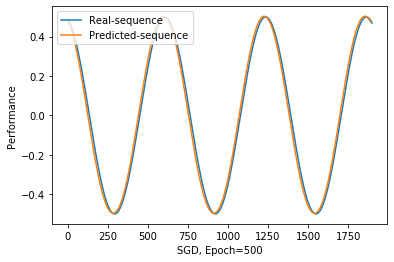

In [37]:
import torch
import torch.nn as nn
from torch.autograd import *
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

INPUT_SIZE=1
HIDDEN_SIZE=16
TIME_STEP=10

EPOCH=500
TRAIN_RATE=0.8
# OPIMIZER='Adam'
OPIMIZER='SGD'
DATA_SIZE=20

def SeriesGen(N):
    x = torch.arange(1, N, 0.01)
    return torch.sin(x)+torch.cos(x)#+torch.pow(x,2)+2


def trainDataGen(seq, k):
    dat = list()
    L = len(seq)
    for i in range(L - k - 1):
        indat = seq[i:i + k]
        outdat = seq[i + 1:i + k + 1]
        dat.append((indat, outdat))
    return dat

'''数据归一化到0-1'''
def normalization(y):
    max_value = np.max(y)
    min_value = np.min(y)
    scalar = max_value - min_value
    y = list(map(lambda x: x / scalar, y))
    return  y

'''产生数据'''

y = SeriesGen(DATA_SIZE).numpy()
y=normalization(y)
dat = trainDataGen(y, TIME_STEP)

'''训练数据和测试数据设置'''
train_size = int(len(dat) * TRAIN_RATE)
test_size = len(dat) - train_size
train_y = dat[:train_size]
test_y = dat[train_size:]


# test_x = range(int(len(dat) * TRAIN_RATE), len(dat))



class LSTMpred(nn.Module):

    def __init__(self, input_size, hidden_dim):
        super(LSTMpred, self).__init__()
        self.input_dim = input_size
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, hidden_dim)
        self.hidden2out = nn.Linear(hidden_dim, 1)
    #     self.hidden = self.init_hidden()
    #
    # def init_hidden(self):
    #     return (Variable(torch.zeros(1, 1, self.hidden_dim)),
    #             Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1))
        outdat = self.hidden2out(lstm_out.view(len(seq), -1))
        return outdat


def ToVariable(x):
    tmp = torch.FloatTensor(x)
    return Variable(tmp)


def model_training():
    print('Start training...\n')

    model = LSTMpred(INPUT_SIZE, HIDDEN_SIZE).cuda()

    loss_function = nn.MSELoss()
    if OPIMIZER=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.001)

    for epoch in range(EPOCH):
        for seq, outs in train_y:
            seq = ToVariable(seq).cuda()
            outs = ToVariable(outs).cuda()
            outs=torch.unsqueeze(outs,1)
            # outs = torch.from_numpy(np.array([outs]))

            optimizer.zero_grad()

            # model.hidden = model.init_hidden()

            modout = model(seq)

            loss = loss_function(modout, outs)
            loss.backward()
            optimizer.step()
        print('Epoch:',epoch,'loss',loss.cpu().data.numpy())

        torch.save(model,'model_rnn.pkl')

def model_test():
    model=torch.load('model_rnn.pkl')
    predDat = []
    for seq, trueVal in dat:
        seq = ToVariable(seq).cuda()
        trueVal = ToVariable(trueVal).cuda()
        predDat.append(model(seq)[-1].cpu().data.numpy()[0])

    fig = plt.figure()
    plt.xlabel(OPIMIZER+', Epoch=%s' % EPOCH)
    plt.ylabel(r'Performance')
    plt.plot(y,label='Real-sequence')
    plt.plot(predDat,label='Predicted-sequence')
#     plt.legend('Real-sequence','Predicted-sequence')
    plt.legend(loc=2,ncol=1)
    plt.show()

if __name__ == '__main__':
    torch.cuda.set_device(0)
#     model_training()

    model_test()
